# Topic Modelling: Airbnb Reviews 
##### Problematique : Were people talking about COVID-19 in the reviews? What are they talking about?

In [13]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as pl
import seaborn as sns

## Dataset

The dataset source is InsideAirbnb.  

We will use the dataset cleaned and labelled during sentiment analysis

"reviews2020-label.csv":
* only contains reviews in 2020
* dataset cleaned (drop empty reviews, drop non-english reviews, drop automatic posts)
* labelled and scored by VADER model ---> 'label' & 'score' columns

In [14]:
# ------ Load the data ------
reviews_2020 = pd.read_csv('reviews2020-label.csv')

In [15]:
# ------ drop the index column ------
reviews_2020= reviews_2020[['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'lang', 'score', 'label']]

In [16]:
reviews_2020.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,label
0,5396,589499566,2020-01-06,28821240,Adrien,"Awesome, safe building, clean room, but more i...",english,0.9652,pos
1,5396,607910128,2020-02-19,26509433,Roberto,Great location and very helpful host.,english,0.8016,pos
2,5396,611549316,2020-02-27,8898065,Brenda,Location location location! This flat is perfe...,english,0.9908,pos
3,5396,612203113,2020-02-29,46597362,Carolyn,Great location. We were a bit bummed the wifi ...,english,0.8917,pos
4,5396,614805142,2020-03-06,269002087,Lilla,This appartment is very nice and clean. It's r...,english,0.9711,pos


## Gensim Word2Vec:  COVID related words in the document

Reason of filtering the data with only COVID-related document is that: 
* I've already run NMF model with the whole cleaned dataset, and COVID related words didn't appear in the top words --> my guess is that not a lot of reviews are talking about lockdown
* Hence, the solution will be finding out COVID related words and filter the dataset with only COVID related reviews

In [17]:
import gensim

In [18]:
# ------  step 1: preprocessing texts ------
documents = reviews_2020['comments'].apply(lambda x: gensim.utils.simple_preprocess(x)).values

# ------ step 2: process documents ------
    # time depends on vector size, here 150
model = gensim.models.Word2Vec(documents,
                              size=150,
                              window=10,
                              min_count=2,
                              workers=4)
model.save('reviews.model')

In [19]:
# ------ find out the most similar words to covid ------
model.wv.most_similar(positive='covid')

[('coronavirus', 0.9132655262947083),
 ('corona', 0.904657244682312),
 ('pandemic', 0.8926323652267456),
 ('lockdown', 0.850027322769165),
 ('outbreak', 0.8311607241630554),
 ('virus', 0.8224941492080688),
 ('crisis', 0.7791687250137329),
 ('situation', 0.7694476246833801),
 ('quarantine', 0.7148688435554504),
 ('shutting', 0.7144385576248169)]

In [20]:
model.wv.most_similar(positive='coronavirus')

[('covid', 0.9132655262947083),
 ('corona', 0.8810322880744934),
 ('outbreak', 0.8611302375793457),
 ('virus', 0.8494599461555481),
 ('pandemic', 0.8484677076339722),
 ('crisis', 0.8294463157653809),
 ('lockdown', 0.8261011242866516),
 ('situation', 0.799746036529541),
 ('ban', 0.7758933305740356),
 ('cancelled', 0.7706592082977295)]

In [21]:
model.wv.most_similar(positive='lockdown')

[('pandemic', 0.896315336227417),
 ('covid', 0.850027322769165),
 ('coronavirus', 0.8261011242866516),
 ('outbreak', 0.763656735420227),
 ('corona', 0.7627658843994141),
 ('december', 0.7256456017494202),
 ('virus', 0.72247314453125),
 ('crisis', 0.7224064469337463),
 ('restrictions', 0.7032448649406433),
 ('ban', 0.6908512115478516)]

### Here are the words I decided as the condition of COVID related reviews :
covid, corona, pandemic, outbreak, lockdown, virus, crisis, quarantine, coronavirus, confinement, situation, shutting, ban, restrictions

In [22]:
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if lemmatize_stemming(token) not in ('pari', 'apart', 'stay','place'):
                result.append(lemmatize_stemming(token))
            
    return result

In [23]:
reviews_2020['tokens'] = reviews_2020['comments'].apply(preprocess)

NameError: name 'lemmatize_stemming' is not defined

In [ ]:
reviews_2020.head()

In [ ]:
# ------ create a function to filter only COVID-19 related reviews ------

def talk_covid(text):
    m = re.match(r".*( covid | corona | pandemic| outbreak| lockdown| virus | crisis | quarantine| coronavirus | confinement| situation| shutting | ban | restrictions ).*",text)
    if m:
        return True
    else:
        False

In [ ]:
# ------ apply the function  ------
reviews_2020['covid']= reviews_2020['comments'].apply(lambda x: talk_covid(x))

In [ ]:
# ------ print some examples of filtered review  ------

i=0
for element in reviews_2020.loc[ reviews_2020['covid']==True ]['comments']:
    i = i++1
    if i <5:
        print(i)
        print(element)
        print("-------")

In [ ]:
# ------ filtered dataset  ------
covid = reviews_2020.loc[ reviews_2020['covid']==True  ]

In [ ]:
covid.head()

In [ ]:
# ------ shape of the filtered dataset ------
covid.shape

In [ ]:
# ------ COVID reviews length distribution ------
sns.distplot(covid["comments"].str.len())

In [ ]:
# ------ mean sentiment score  ------
covid['score'].mean()

In [ ]:
covid['label'].value_counts()

In [ ]:
covid['label'].value_counts()/len(covid)

In [ ]:
# ------ distribution of sentiment score ------

covid['score'].plot(kind='hist')
pl.title("COVID-RELATED Reviews")

In [ ]:
# ------ plot the distribution of the scores for positive and negative reviews  ------
sns.distplot(covid.loc[covid['label']=='pos', 'score'])
sns.distplot(covid.loc[covid['label']=='neg', 'score']);
plt.legend(labels=['positive', 'negative'])

------------

# NMF Modelling
Objective: to find the top topics in COVID-related reviews  
Dataset : covid-realted reviews ( covid )

In [ ]:
import nltk
nltk.download('worTaidnet')

## Data Preprocessing

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [ ]:
# ------ Loading Gensim and nltk libraries ------

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(400)

In [ ]:
# ------ stemmer ------ #

stemmer = SnowballStemmer("english")

In [ ]:
# ------ function to perform the pre processing steps on the entire dataset ------

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [ ]:
# ------ generate the preprocessed data------ #

preprocessed= [" ".join(preprocess(covid.comments[idx])) for idx in covid.index]

### Tfidf & NMF

In [ ]:
# ------ prepare for Tfidf & NMF modelling ------ #

n_features = 4000
n_components = 3
n_top_words = 20

we will also remove custom stop words during before vectorizing:  
'would', 'apart', 'stay'

In [ ]:
# ------ Tfidf vectorize the text ------ #

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = [ 'would', 'apart', 'stay']
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

### !!! the section below is long to run

In [ ]:
# ------ NMF topic modelling ------ #
#   alpha=0 means no regularization, l1_ratio=.5, the penalty is a combination of L1 and L2

from sklearn import decomposition
nmf = decomposition.NMF(n_components = n_components, max_iter = 200, random_state=1, alpha=.1, l1_ratio=.5)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()

# ------ Print top words in each topic ------ #

for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
# ------ generate topic key words ------ #

def show_topics(vectorizer=tfidf, model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, model=nmf, n_words=20)        

# ------ Topic - Keywords Dataframe ------ #
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Here we can see the three topics are quite different topics :  
* Topic 0 : Location/Couples/Recommend
* Topic 1 : Coronavirus/Refund/Cancellation
* Topic 2 : Nice/Clean/Help

In [ ]:
# ------ Define Topic Names ------ #
Topics_theme = ['Great/Location/Recommend', 'Coronavirus/Refund/Cancellation', 'Nice/Clean/Host']
df_topic_keywords['topic_theme'] = Topics_theme

In [ ]:
df_topic_keywords.set_index('topic_theme', inplace=True)

In [ ]:
# ------ Keywords - Topic Dataframe ------ #
df_topic_keywords.T

In [ ]:
# ------ Create Document - Topic Matrix ------ #
nmf_output = nmf.transform(tfidf) 

# ------ column names ------ #
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# ------ index names ------ #
docnames = ["Doc" + str(i) for i in range(len(covid))]

# ------ Make the pandas dataframe ------ #
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=covid.index)

# ------ Get dominant topic for each document ------#
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
covid['topic'] =  dominant_topic

In [ ]:
covid.head()

In [ ]:
topic_2 = covid.loc[covid['topic']==1]

In [ ]:
mostpos = topic_2.sort_values(by='score', ascending=False)['comments']

In [ ]:
topic_2.sort_values(by='score', ascending=False)

In [78]:
# ------ print some examples of filtered review  ------

i=0
for element in mostpos:
    i = i++1
    if i <15:
        print(i)
        print(element)
        print("-------")

1
We unfortunately never got the chance to see Anna's wonderful apartment due to the coronavirus situation, but the communication from Anna was really quick and we were fortunate enough to receive a full refund. However, we hope to be able to book in the future and we are sure the apartment is as lovely as the pictures.
-------
2
Jeanne’s flat looked absolutely perfect for my trip. After booking, we learned that there was a mix up and the property had already been booked to someone else. Jeanne was fantastic in communicating with me and ensuring I was able to get a full refund having already paid and then finding out later that the property was unavailable.  Airbnb contacted me to inform me that Jeanne had reached out to Airbnb to explain the situation and to ensure I would be given a full refund. Her commitment to my refund was superb. Having not rented the property, I can not say anything about the property, so my review is useless there, but in Jeanne’s communication and commitment 

In [73]:
# ------ count number of each topic ------ #
covid['topic'].value_counts()

0    301
1     40
2     32
Name: topic, dtype: int64

In [481]:
# ------ Print mean sentiment score for each topic ------ #
for i in range(n_components):
    topic= "Topic " + str(i+1)
    print(topic)
    print(Topics_theme[i])
    print(covid.loc[covid['topic']==i]['score'].mean())
    print('----------------')
    i++1

Topic 1
Location/Couples/Recommend
0.8097973421926908
----------------
Topic 2
Coronavirus/Refund/Cancellation
-0.14865250000000002
----------------
Topic 3
Nice/Clean/Help
0.6777093749999997
----------------


### Word Cloud for each topic

In [482]:
# ------ Create pandas dataframe for the topics ------ #
mydf = pd.DataFrame({"feature_name": feature_names}) 

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

reviews_topic1 = []
reviews_topic2 = []
reviews_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    reviews_topic1.append((key, num1))
    reviews_topic2.append((key, num2))
    reviews_topic3.append((key, num3))
    reviews_topic4.append((key, num4))

reviews_topic1 = sorted(reviews_topic1, key=lambda myword: myword[1], reverse=True)
reviews_topic2 = sorted(reviews_topic2, key=lambda myword: myword[1], reverse=True)
reviews_topic3 = sorted(reviews_topic3, key=lambda myword: myword[1], reverse=True)


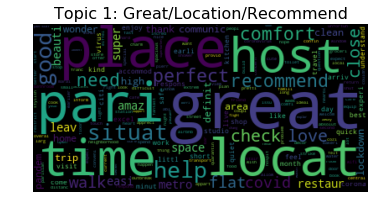

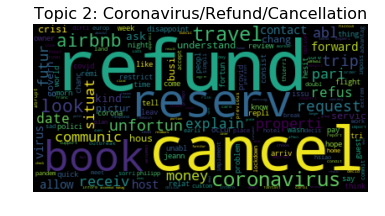

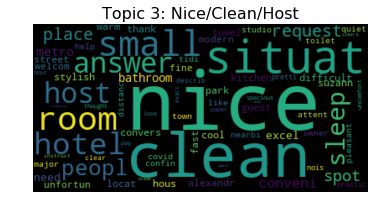

In [514]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    title = 'Topic %s' %str(topic_number) + ": " + Topics_theme[topic_number-1]
    plt.title(title, size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(reviews_topic1), topic_number=1)
draw_wordcloud(dict(reviews_topic2), topic_number=2)
draw_wordcloud(dict(reviews_topic3), topic_number=3)


In [427]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
DT_new = nmf.transform(tfidf_new)

-------------

# Further research : LDA Modelling  (not included in the thesis)

In [428]:
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

## Data Preprocessing

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [538]:
# ------ this time we will change the stemmer ------ #
stemmer = PorterStemmer()

In [539]:
# ------  function to perform the pre processing steps on the entire dataset ------ #

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if lemmatize_stemming(token) not in ('pari', 'apart', 'stay','place'):
                result.append(lemmatize_stemming(token))
            
    return result

In [540]:
processed_docs = []

for doc in covid['comments'] :
    processed_docs.append(preprocess(doc))

In [541]:
# ------ Preview 'processed_docs' ------ #
print(processed_docs[:2])

[['okay', 'write', 'situat', 'world', 'firstli', 'famili', 'wife', 'toddler', 'travel', 'europ', 'arriv', 'franc', 'visit', 'sister', 'colmar', 'sudden', 'ongo', 'pandem', 'covid', 'worsen', 'situat', 'franc', 'lockdown', 'mean', 'trip', 'colmar', 'cancel', 'stick', 'groceri', 'exercis', 'night', 'smaller', 'decid', 'need', 'space', 'kid', 'spend', 'night', 'luckili', 'jean', 'francoi', 'avail', 'move', 'earli', 'thank', 'allow', 'noon', 'govern', 'peopl', 'noon', 'spacey', 'elev', 'typic', 'european', 'expect', 'mind', 'bedroom', 'comfort', 'live', 'area', 'larg', 'kitchen', 'proper', 'amaz', 'thing', 'locat', 'supermarket', 'butcher', 'boulangeri', 'fromageri', 'legendari', 'stohrer', 'patisseri', 'love', 'locat', 'best', 'neighborhood', 'montorgueil', 'wish', 'famili', 'great', 'health', 'bless', 'hard', 'time', 'care', 'regard', 'indonesia'], ['studio', 'great', 'need', 'stair', 'kitchen', 'perfect', 'carol', 'host', 'stress', 'covid', 'travel', 'period', 'instead', 'cancel', 'host

In [542]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [543]:
# ------ Checking dictionary created ------ #

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 allow
1 amaz
2 area
3 arriv
4 avail
5 bedroom
6 best
7 bless
8 boulangeri
9 butcher
10 cancel


In [544]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [545]:
# ------ Preview BOW for our sample preprocessed document ------ #
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 39 ("locat") appears 1 time.
Word 59 ("situat") appears 1 time.
Word 98 ("commun") appears 1 time.
Word 120 ("good") appears 1 time.
Word 131 ("metro") appears 1 time.
Word 136 ("sure") appears 1 time.
Word 164 ("station") appears 1 time.
Word 167 ("walk") appears 1 time.
Word 177 ("flat") appears 1 time.
Word 190 ("right") appears 1 time.
Word 236 ("marai") appears 1 time.
Word 281 ("window") appears 1 time.
Word 282 ("advantag") appears 1 time.
Word 377 ("bastil") appears 1 time.
Word 378 ("build") appears 1 time.
Word 379 ("clear") appears 1 time.
Word 380 ("dark") appears 1 time.
Word 381 ("differ") appears 1 time.
Word 382 ("main") appears 1 time.
Word 383 ("minut") appears 1 time.
Word 384 ("neg") appears 1 time.
Word 385 ("outsid") appears 1 time.
Word 386 ("point") appears 1 time.
Word 387 ("renov") appears 1 time.
Word 388 ("room") appears 1 time.
Word 389 ("scaffold") appears 1 time.
Word 390 ("smooth") appears 1 time.
Word 391 ("vosg") appears 1 time.


In [561]:
# ------ LDA multicore  ------ #

# ------ Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model' ------ #

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dictionary,                                    
                                   passes = 90,
                                   workers = 2)

In [562]:
# ------ For each topic, we will explore the words occuring in that topic and its relative weight ------ #
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.014*"refund" + 0.013*"host" + 0.012*"airbnb" + 0.012*"book" + 0.011*"situat" + 0.009*"leav" + 0.008*"time" + 0.008*"cancel" + 0.007*"properti" + 0.007*"clean"


Topic: 1 
Words: 0.013*"situat" + 0.009*"good" + 0.008*"recommend" + 0.008*"host" + 0.007*"airbnb" + 0.007*"night" + 0.006*"need" + 0.005*"time" + 0.005*"peopl" + 0.005*"clean"


Topic: 2 
Words: 0.012*"room" + 0.012*"clean" + 0.012*"host" + 0.009*"like" + 0.008*"situat" + 0.008*"leav" + 0.008*"towel" + 0.007*"thing" + 0.007*"small" + 0.007*"nice"


Topic: 3 
Words: 0.022*"great" + 0.020*"locat" + 0.015*"situat" + 0.014*"time" + 0.013*"host" + 0.011*"help" + 0.010*"recommend" + 0.009*"need" + 0.009*"comfort" + 0.009*"walk"




### LDA Visualization

In [563]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/Users/IvoryDaae/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.153359  0.008581       1        1  56.062828
0      0.079986 -0.079294       2        1  18.321266
1      0.000196 -0.034036       3        1  12.989900
2      0.073177  0.104748       4        1  12.626004, topic_info=    Category        Freq    Term       Total  loglift  logprob
811  Default   34.000000  refund   34.000000  30.0000  30.0000
388  Default   47.000000    room   47.000000  29.0000  29.0000
801  Default   56.000000  airbnb   56.000000  28.0000  28.0000
28   Default  174.000000   great  174.000000  27.0000  27.0000
514  Default   48.000000    book   48.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
70    Topic4   10.040084    time  147.350052  -0.6168  -5.1375
344   Topic4    5.874732   guest   19.391865   0.8752  -5.6734
38    Topic4    6.497768    live   33.276649   0.4360  -5.5726
55    Topic4    6.018328   peopl   42.007706   0.1264  -5.6493
28    Topic4    5.977167   great  174.062424  -1.3021  -5.6561

[305 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
93        1  0.525957     abl
93        2  0.304501     abl
93        3  0.110728     abl
93        4  0.055364     abl
969       4  0.644385  advanc
...     ...       ...     ...
115       3  0.204939    work
115       4  0.102469    work
1047      4  0.927391  worker
510       2  0.505351  wouldn
510       3  0.505351  wouldn

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

## Other Viz LDA

## What is the Dominant topic and its percentage contribution in each document

In [564]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=preprocessed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4999,"room, clean, host, like, situat, leav, towel, thing, small, nice","[okay, write, situat, world, firstli, famili, wife, toddler, travel, europ, arriv, franc, visit,..."
1,1,3.0,0.7362,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[studio, great, need, stair, kitchen, perfect, carol, host, stress, covid, travel, period, inste..."
2,2,0.0,0.7876,"refund, host, airbnb, book, situat, leav, time, cancel, properti, clean","[commun, michel, easi, help, messag, unfortun, world, shut, covid, unabl, connect, flight, miche..."
3,3,2.0,0.5735,"room, clean, host, like, situat, leav, towel, thing, small, nice","[pretti, expect, pictur, arriv, easi, great, locat, good, understand, commun, host, rat, contact..."
4,4,3.0,0.6638,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[wonder, care, host, happen, covid, pandem, start, gain, momentum, franc, host, sure, feel, welc..."
5,5,3.0,0.7302,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[adélaïd, week, excel, host, touch, trip, great, time, shut, viru, pandem, small, need, neighbor..."
6,6,3.0,0.9637,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[nice, clean, need, subway, station, nearbi, train, station, train, airport, walk, distanc, sara..."
7,7,3.0,0.7026,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[trip, covid, lockdown, vincent, perfect, central, locat, clean, easili, stair, floor, commun, e..."
8,8,3.0,0.5447,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[vincent, kindli, receiv, time, parisian, flat, arrondiss, follow, covid, regul, feel, right, ho..."
9,9,3.0,0.9875,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[love, close, walk, great, restaur, market, public, transport, walk, distanc, market, close, wal..."


## The most representative sentence for each topic

In [565]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9938,"refund, host, airbnb, book, situat, leav, time, cancel, properti, clean","[avoid, cost, leav, aw, night, book, night, host, accept, book, earli, check, request, messag, m..."
1,1.0,0.9909,"situat, good, recommend, host, airbnb, night, need, time, peopl, clean","[walk, smell, like, cigarett, marathon, contact, host, say, probabl, previou, guest, look, hole,..."
2,2.0,0.9979,"room, clean, host, like, situat, leav, towel, thing, small, nice","[potenti, futur, guest, go, factual, review, possibl, tri, remov, commentari, feel, need, explai..."
3,3.0,0.9926,"great, locat, situat, time, host, help, recommend, need, comfort, walk","[husband, check, marc, latin, quarter, week, french, govern, implement, home, order, fight, covi..."


## Frequency Distribution of Word Counts in Documents

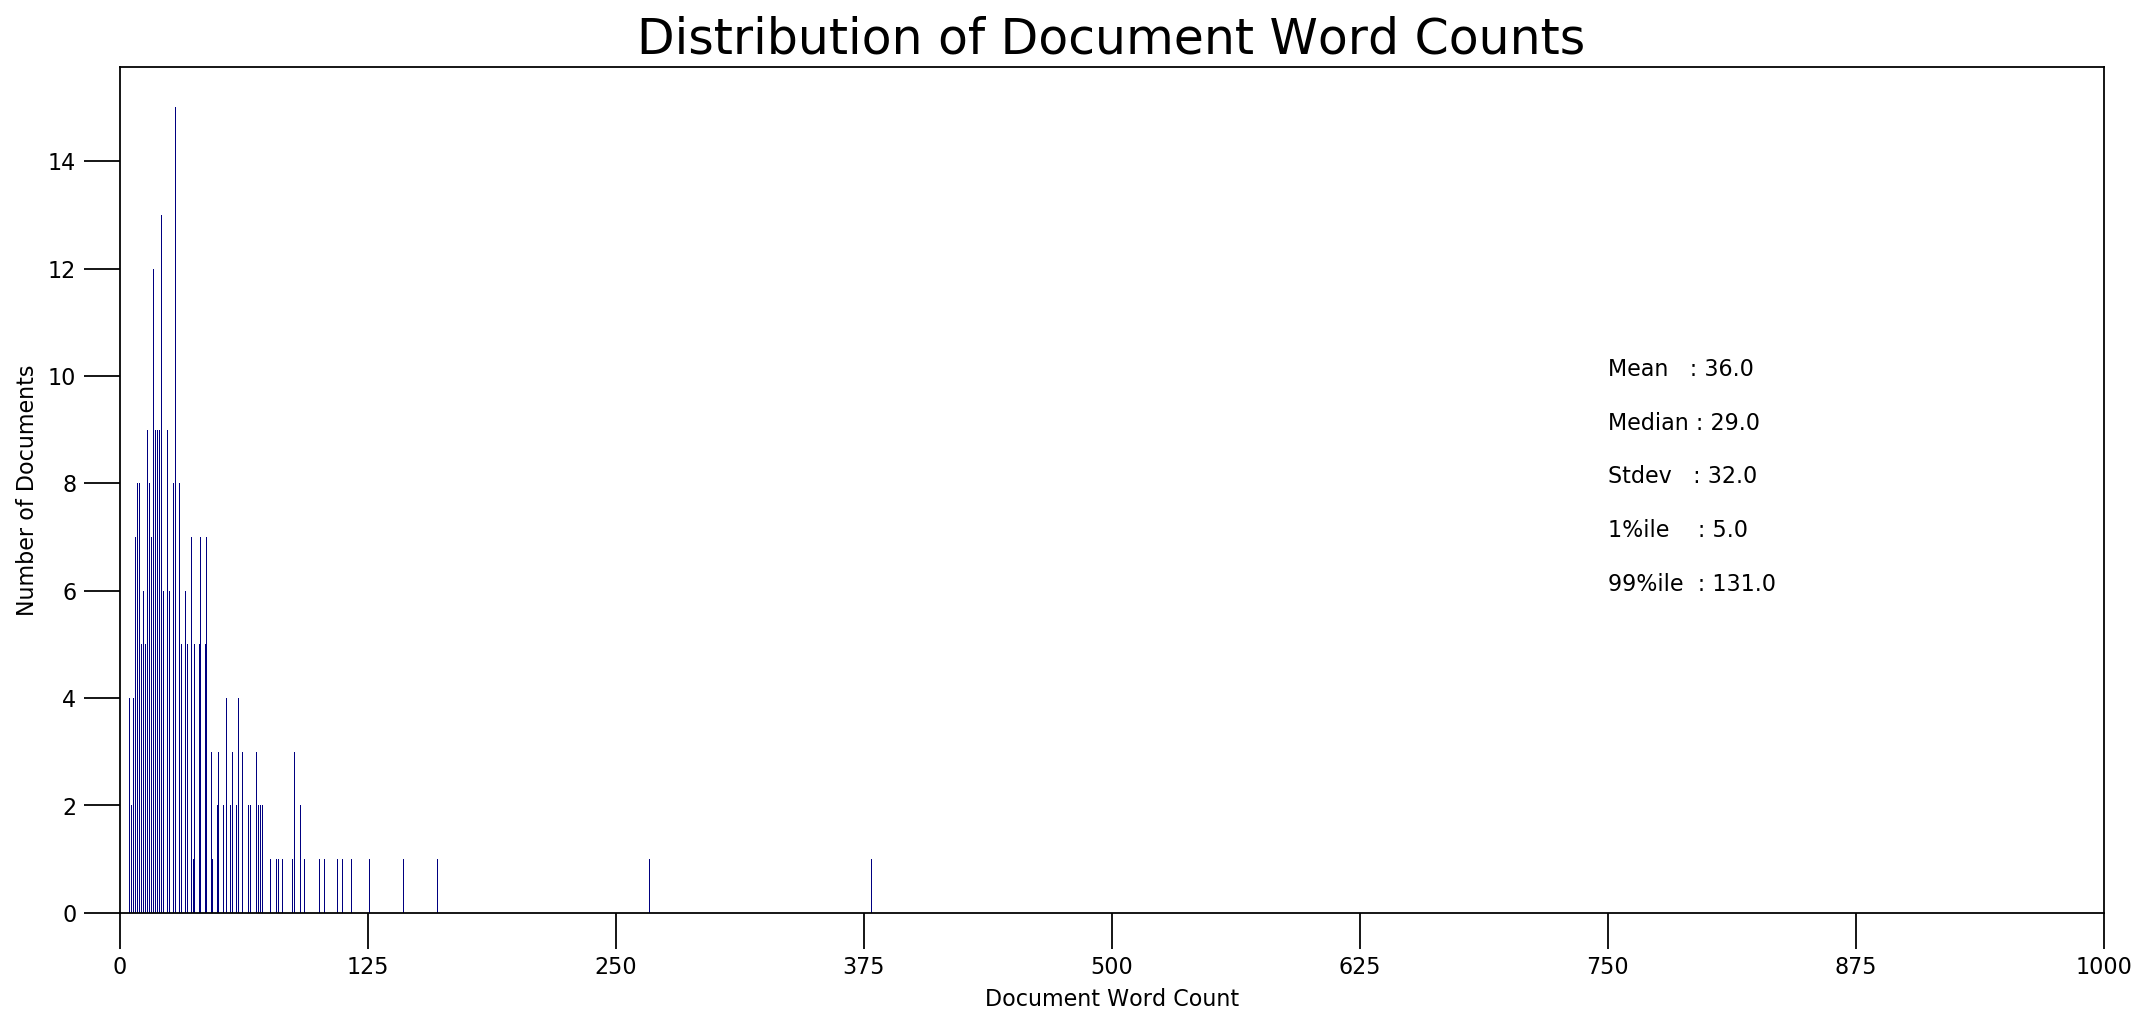

In [571]:

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 10, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  9, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

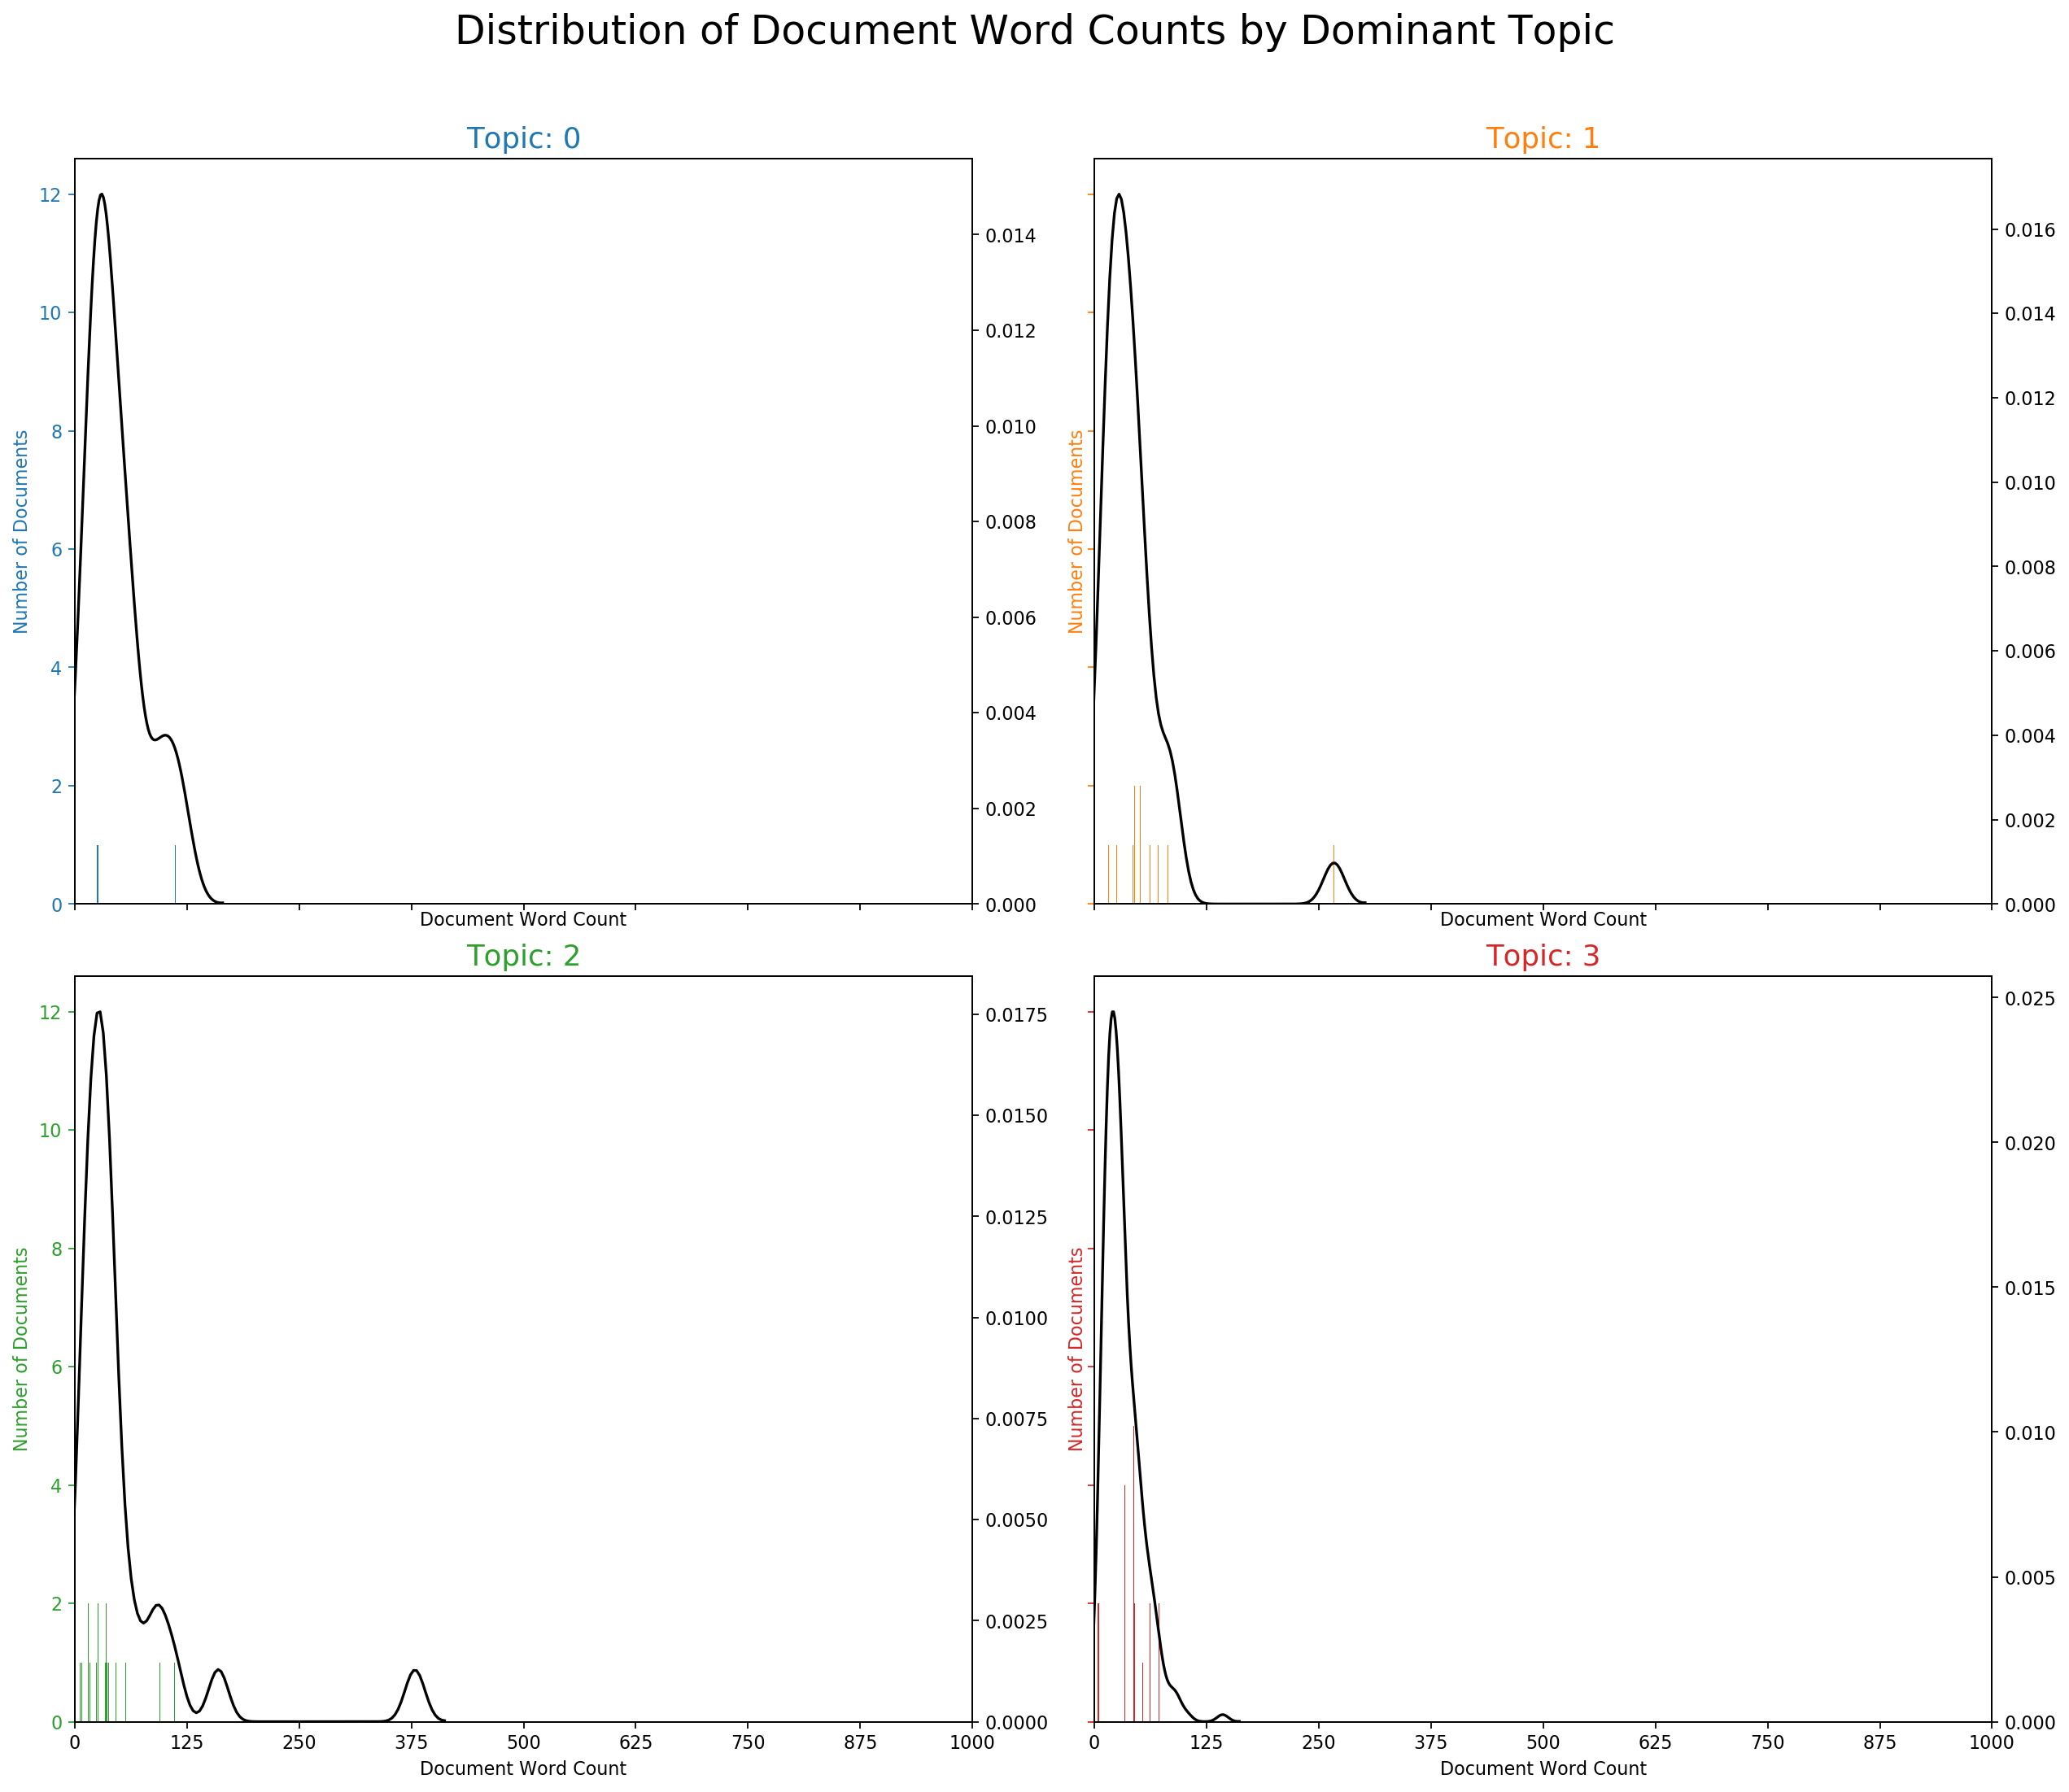

In [567]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Clouds of Top N Keywords in Each Topic

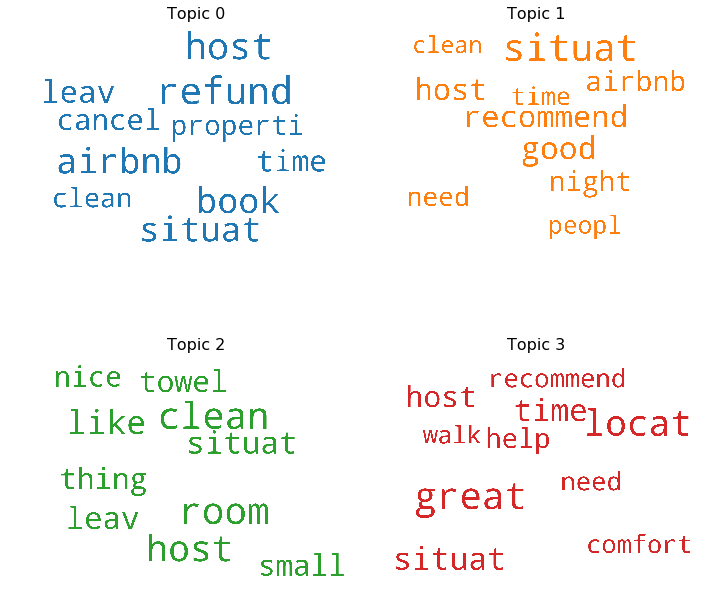

In [568]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

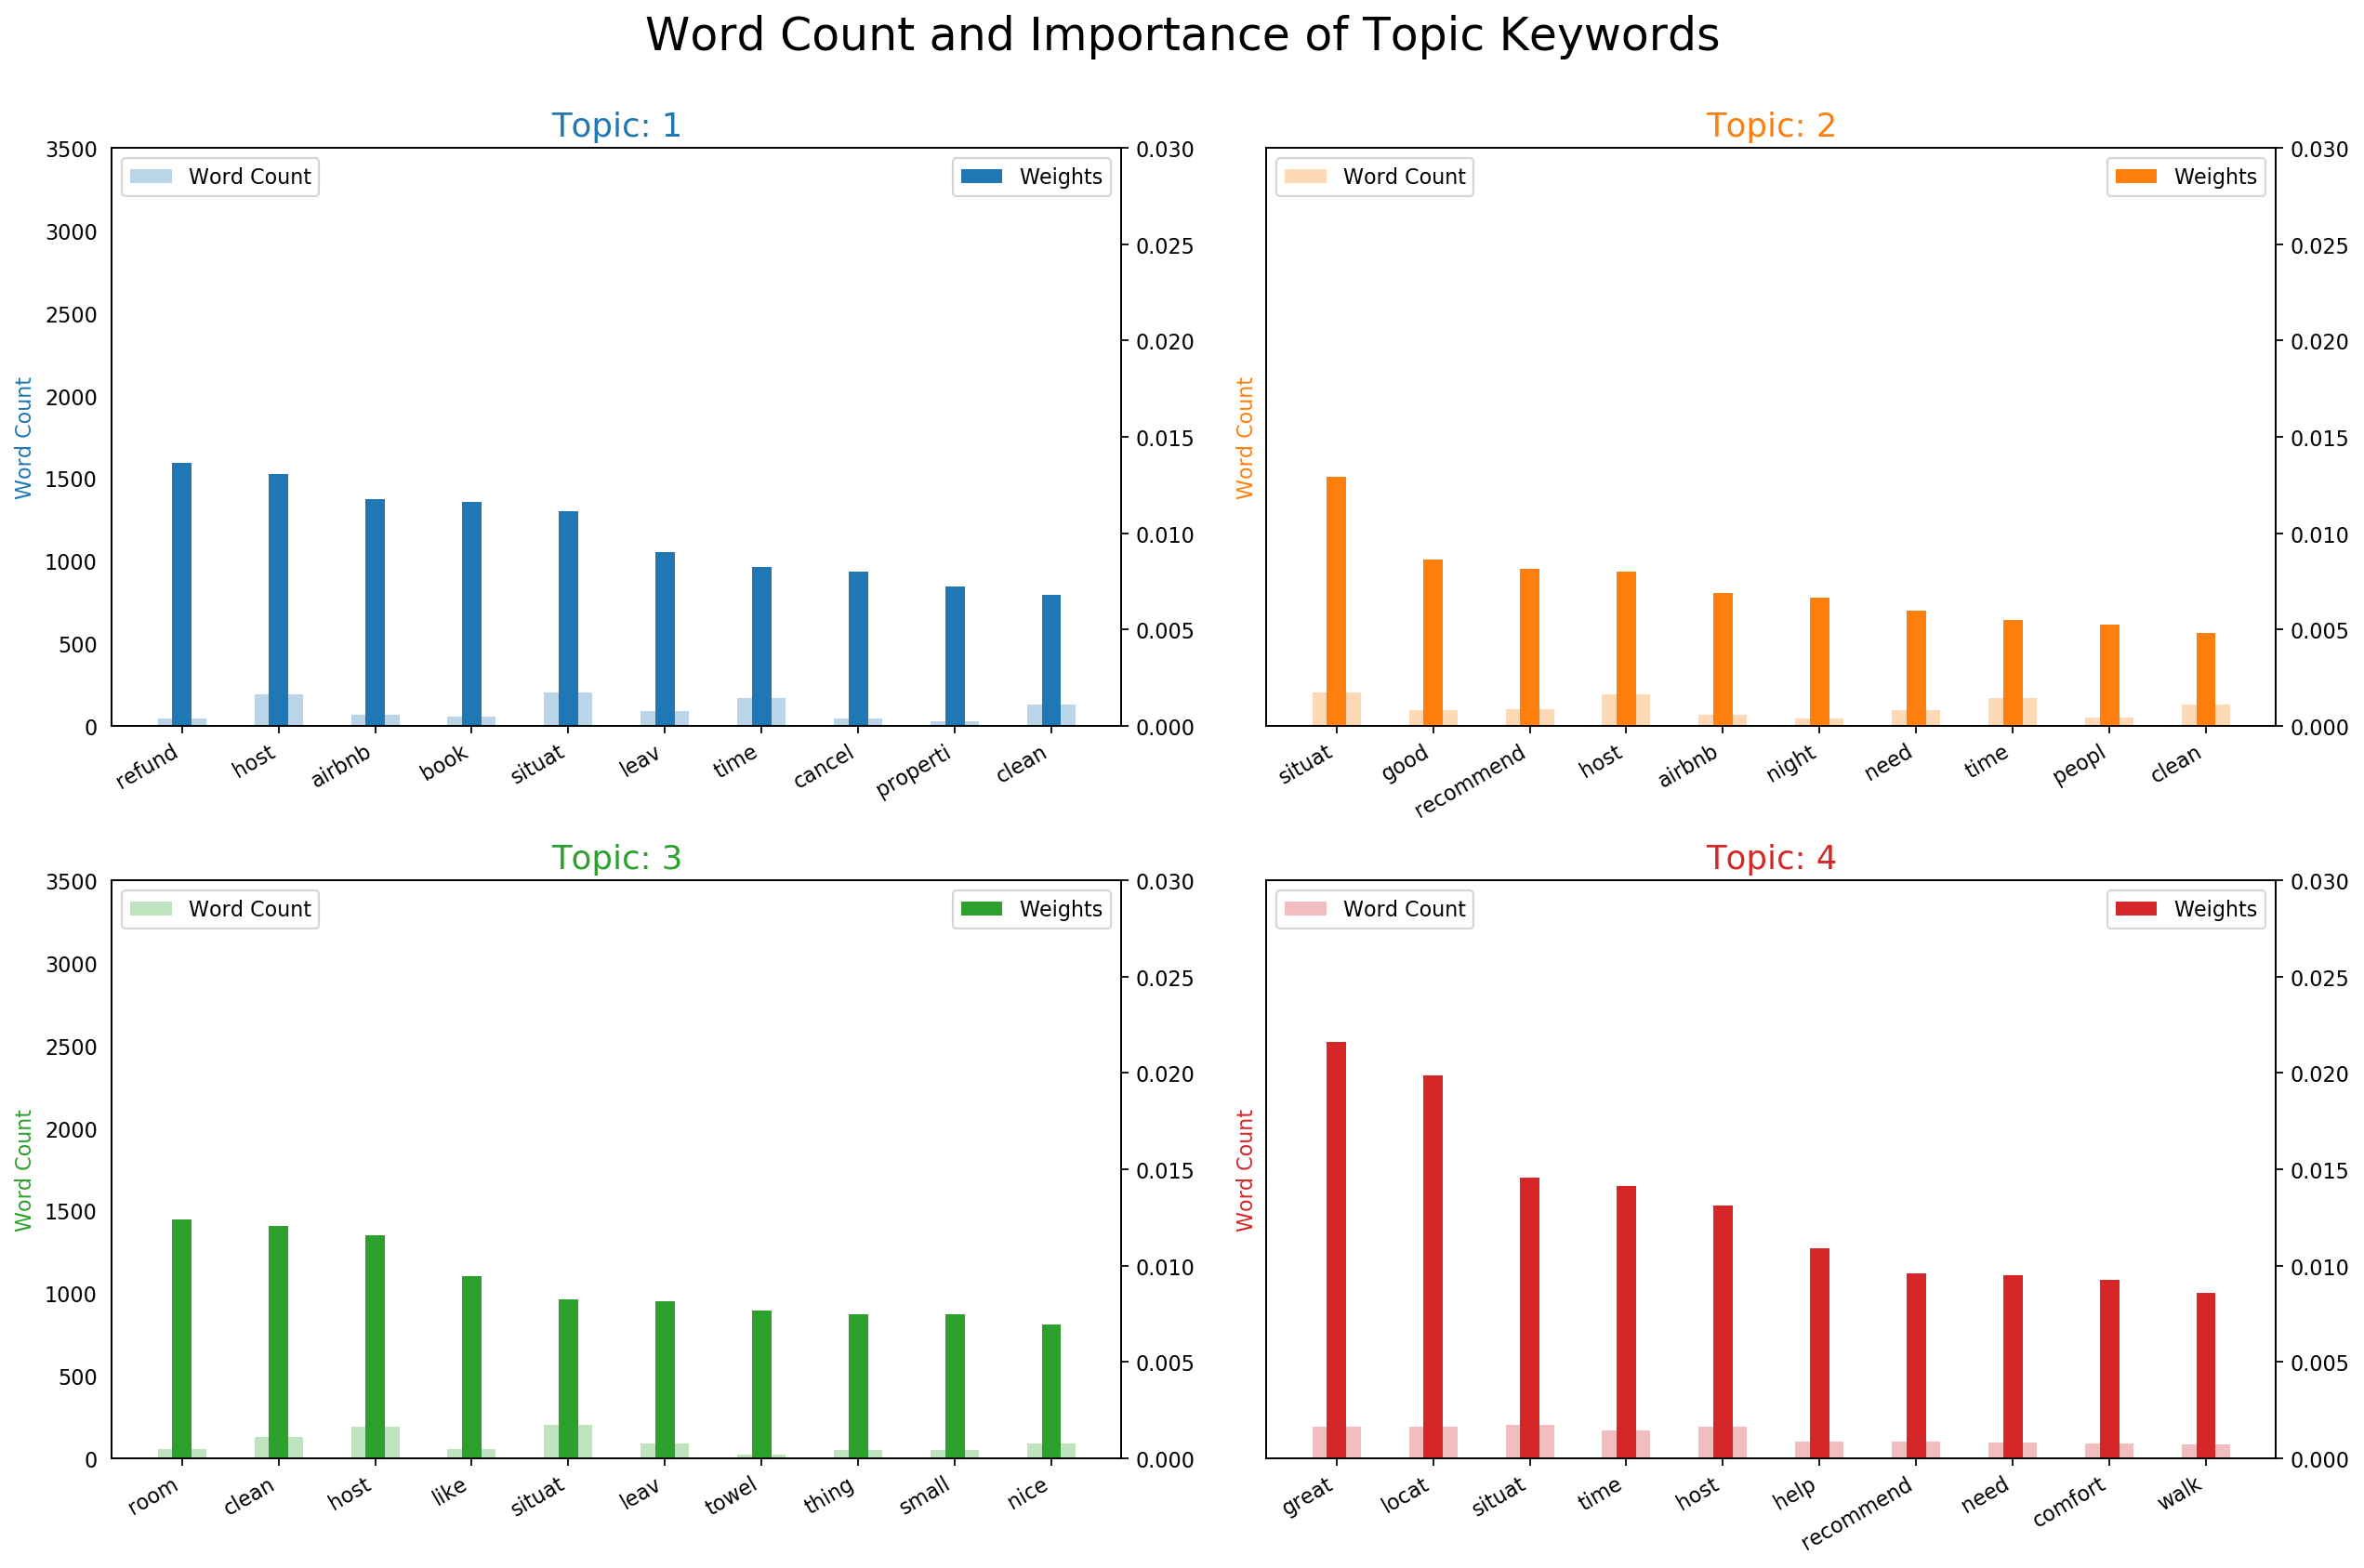

In [574]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## t-SNE Clustering Chart

In [573]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(lda_model[bow_corpus]):
#     topic_weights.append([w for i, w in row_list[0]])

# n-1 rows each is a vector with i-1 posisitons, where n the number of documents 
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model[bow_corpus]:
    tmp = np.zeros(4)
    for i, w in row_list: 
        tmp[i] = w
        topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 945 samples in 0.001s...
[t-SNE] Computed neighbors for 945 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 945 / 945
[t-SNE] Mean sigma: 0.004020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.130466
[t-SNE] KL divergence after 1000 iterations: -0.041759


Loading BokehJS ...